In [1]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# Set your base folder
base_path = "Datasets"
raw_path = os.path.join(base_path, "Raw_Images")
ref_path = os.path.join(base_path, "Reference_Images")

# List image files
raw_images = sorted(glob(os.path.join(raw_path, "*.tiff")))
ref_images = sorted(glob(os.path.join(ref_path, "*.jpeg")))

# Load first image pair
raw_img = cv2.imread(raw_images[0], cv2.IMREAD_UNCHANGED)  # 16-bit grayscale
ref_img = cv2.imread(ref_images[0])                         # 8-bit RGB
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)          # Convert to RGB for matplotlib

# Info
print(f"Raw Image: shape={raw_img.shape}, dtype={raw_img.dtype}, min={raw_img.min()}, max={raw_img.max()}")
print(f"Reference Image: shape={ref_img.shape}, dtype={ref_img.dtype}")




Raw Image: shape=(4418, 4418), dtype=uint16, min=0, max=9538
Reference Image: shape=(4418, 4418, 3), dtype=uint8


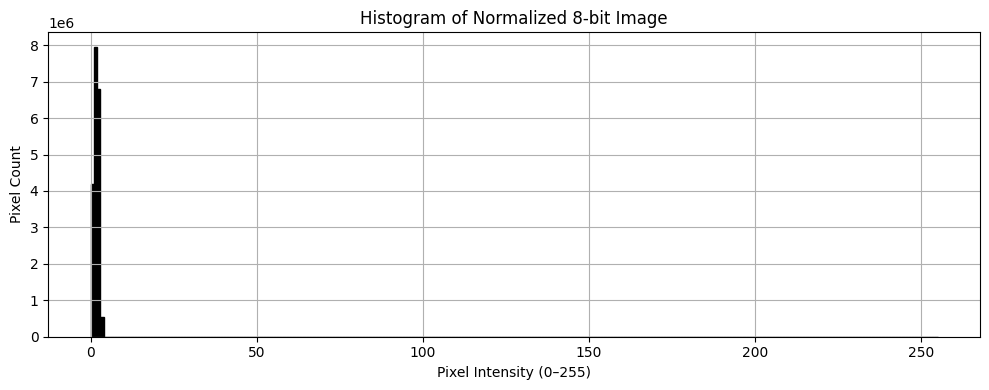

In [2]:
# Normalize to 0–255 and convert to 8-bit
raw_img_norm = cv2.normalize(raw_img, None, 0, 255, cv2.NORM_MINMAX)
raw_img_8bit = raw_img_norm.astype(np.uint8)

plt.figure(figsize=(10, 4))
plt.hist(raw_img_8bit.ravel(), bins=256, color='black', edgecolor='black')
plt.title("Histogram of Normalized 8-bit Image")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Pixel Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)
def apply_unsharp_mask(img, blur_ksize=(9, 9), amount=1.5):
    blurred = cv2.GaussianBlur(img, blur_ksize, 0)
    sharpened = cv2.addWeighted(img, 1 + amount, blurred, -amount, 0)
    return sharpened

In [4]:
clahe_img = apply_clahe(raw_img_8bit)
unsharp_img = apply_unsharp_mask(raw_img_8bit)
combined=apply_unsharp_mask(clahe_img)


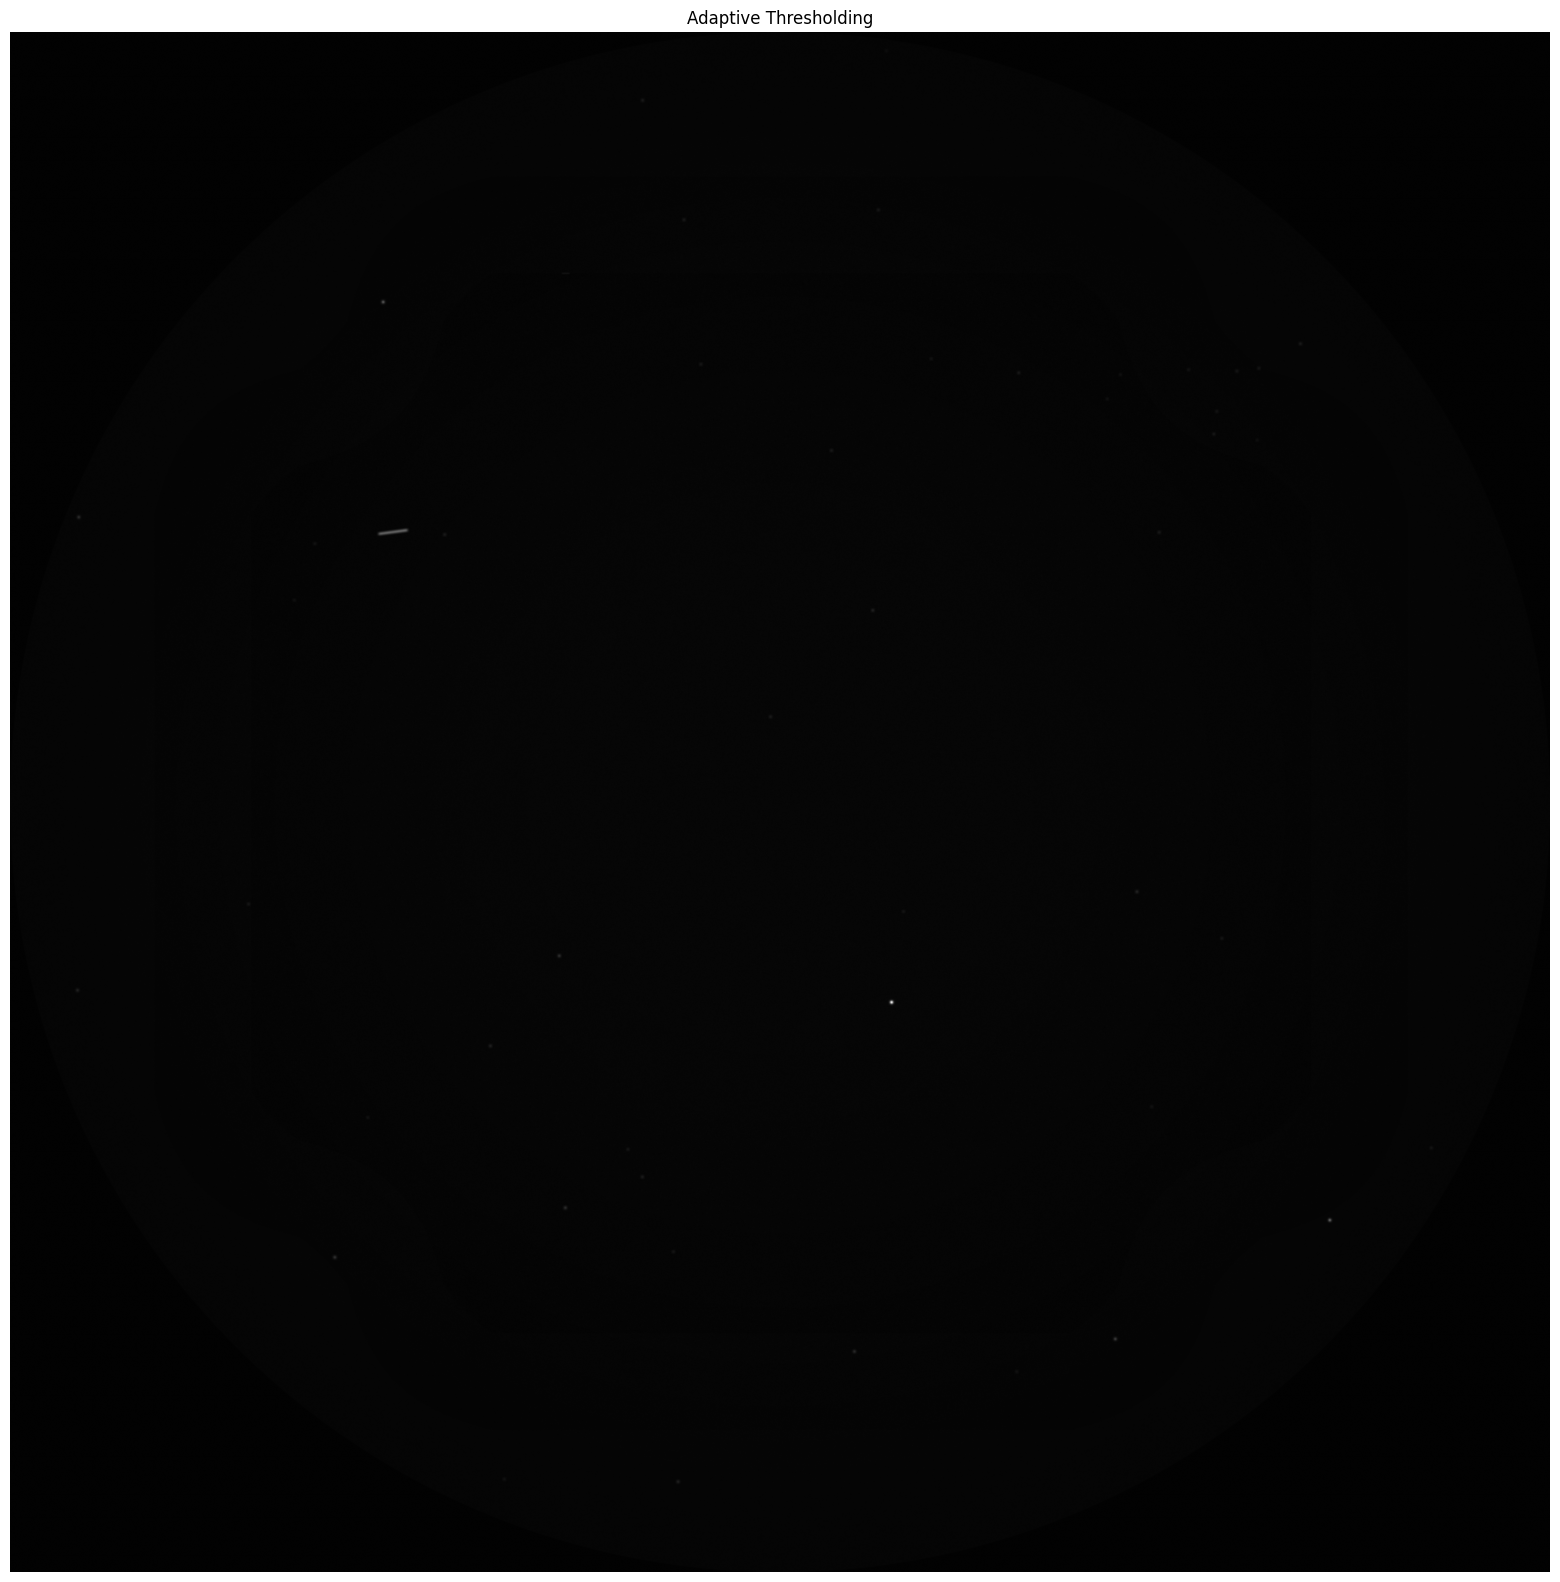

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(clahe_img, cmap='gray')
plt.title("Adaptive Thresholding")
plt.axis('off')
plt.show()

In [12]:
!pip install astropy pillow


   ---------------------------------------- 0.0/6.5 MB ? eta -:--:--
   --- ------------------------------------ 0.5/6.5 MB 12.2 MB/s eta 0:00:01
   ---- ----------------------------------- 0.8/6.5 MB 3.8 MB/s eta 0:00:02
   --------- ------------------------------ 1.6/6.5 MB 2.6 MB/s eta 0:00:02
   ---------------- ----------------------- 2.6/6.5 MB 3.2 MB/s eta 0:00:02
   --------------------- ------------------ 3.4/6.5 MB 3.7 MB/s eta 0:00:01
   --------------------------- ------------ 4.5/6.5 MB 3.6 MB/s eta 0:00:01
   -------------------------------- ------- 5.2/6.5 MB 3.6 MB/s eta 0:00:01
   -------------------------------- ------- 5.2/6.5 MB 3.6 MB/s eta 0:00:01
   --------------------------------- ------ 5.5/6.5 MB 3.2 MB/s eta 0:00:01
   ----------------------------------- ---- 5.8/6.5 MB 2.9 MB/s eta 0:00:01
   -------------------------------------- - 6.3/6.5 MB 2.7 MB/s eta 0:00:01
   ---------------------------------------- 6.5/6.5 MB 2.7 MB/s eta 0:00:00
   ---------------

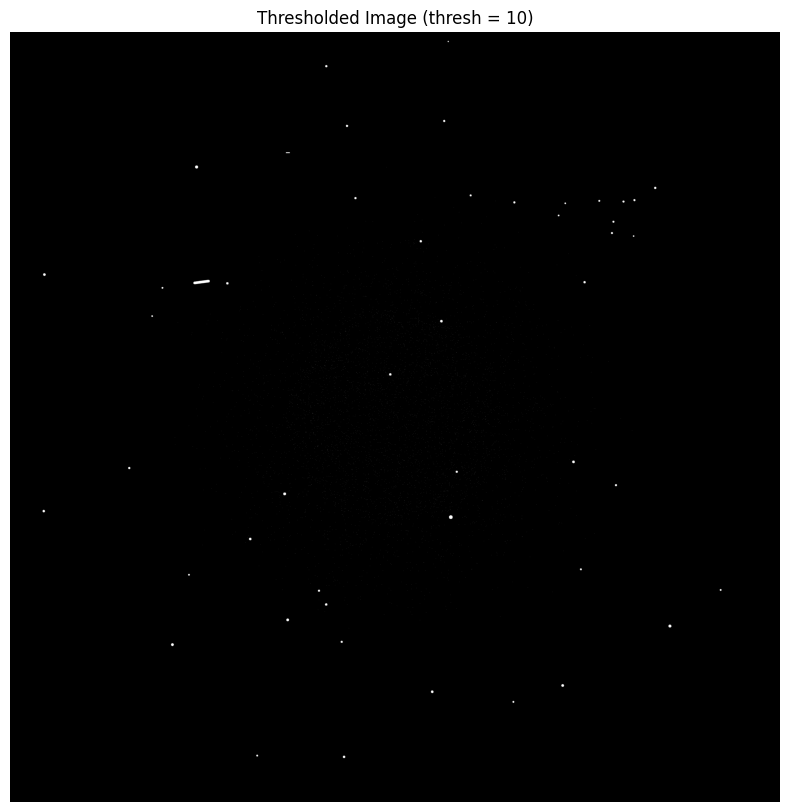

In [7]:
_, thresh_img = cv2.threshold(clahe_img, 10, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(10,10))
plt.imshow(thresh_img, cmap='gray')
plt.title('Thresholded Image (thresh = 10)')
plt.axis('off')
plt.show()

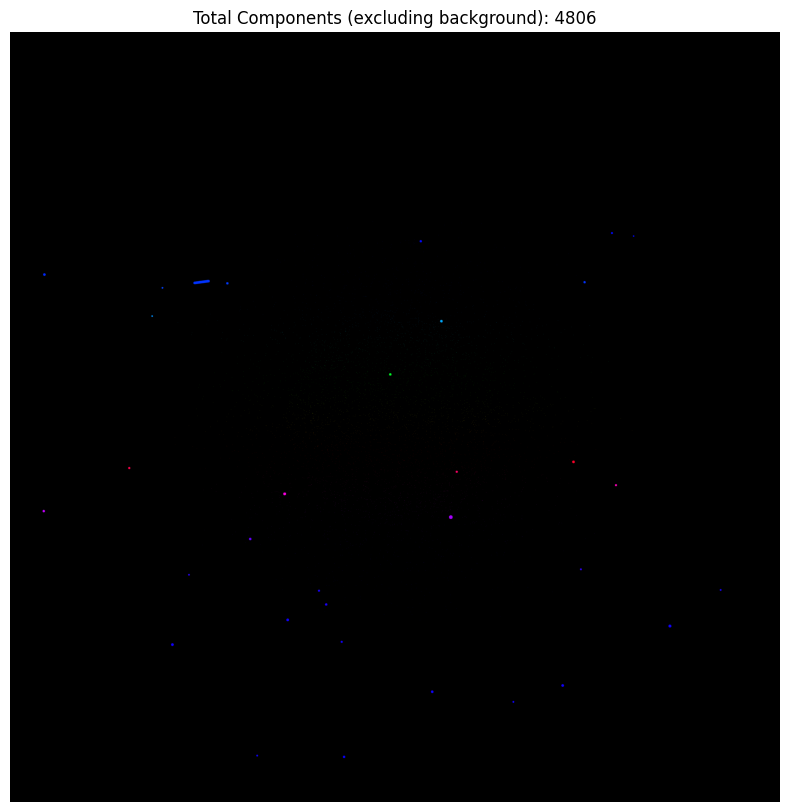

In [11]:
num_labels, labels_im = cv2.connectedComponents(thresh_img)

# Map component labels to colors
label_hue = np.uint8(179 * labels_im / np.max(labels_im))
blank_ch = 255 * np.ones_like(label_hue)
colored_img = cv2.merge([label_hue, blank_ch, blank_ch])

# Convert to BGR for visualization
colored_img = cv2.cvtColor(colored_img, cv2.COLOR_HSV2BGR)

# Set background to black
colored_img[label_hue == 0] = 0

# Display results
plt.figure(figsize=(10, 10))
plt.title(f'Total Components (excluding background): {num_labels - 1}')
plt.imshow(colored_img)
plt.axis('off')
plt.show()

In [17]:
from PIL import Image
import numpy as np
from astropy.io import fits

# Load TIFF image

image = Image.open(r"Datasets\Reference_Images\Reference_Observation_005_Set1.jpeg")

# Convert to grayscale if needed (FITS usually stores 2D data)
if image.mode != 'L':
    image = image.convert('L')

# Convert to NumPy array
image_data = np.array(image)

# Create FITS file
hdu = fits.PrimaryHDU(image_data)
hdul = fits.HDUList([hdu])
hdul.writeto("output_image.fits", overwrite=True)

print("Conversion complete: output_image.fits")


Conversion complete: output_image.fits


In [18]:
# Import the ASTRiDE library.
from astride import Streak

# Read a fits image and create a Streak instance.
streak = Streak(r'output_image.fits')

# Detect streaks.
streak.detect()

# Write outputs and plot figures.
streak.write_outputs()
streak.plot_figures()

c:\projects\Streak-and-Stars\stars\Lib\site-packages\astride\utils\edge.py:126: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  p1, s = leastsq(self.orthogonal_residuals, p0, args=(edge['x'][:-1], edge['y'][:-1]))


<Figure size 1200x900 with 0 Axes>

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage import io, color, filters
from skimage.feature import peak_local_max

# 1. Load and preprocess the image (convert to grayscale)
image = raw_img_8bit.copy()  # Use the normalized 8-bit image
if len(image.shape) > 2:
    image = color.rgb2gray(image)

# 2. Apply edge enhancement (optional, helps with streak detection)
edges = filters.sobel(image)

# 3. Compute Radon transform
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(edges, theta=theta)

# 4. Detect peaks in the Radon transform (streaks)
peaks = peak_local_max(sinogram, threshold_abs=np.mean(sinogram) * 2, num_peaks=5)

# 5. Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')
ax2.imshow(edges, cmap='gray')
ax2.set_title('Edge-enhanced Image')
ax3.imshow(sinogram, cmap='hot', extent=(0, 180, 0, sinogram.shape[0]))
ax3.set_title('Radon Transform (Sinogram)')
ax3.set_xlabel('Angle (deg)')
ax3.set_ylabel('Projection Position')

# Mark detected peaks in the sinogram
for peak in peaks:
    ax3.plot(theta[peak[1]], peak[0], 'ro')  # Red circles mark detected lines

plt.tight_layout()
plt.show()

# (Optional) Reconstruct lines in image space
lines = []
for peak in peaks:
    angle = theta[peak[1]]
    distance = peak[0]
    lines.append((angle, distance))

print("Detected streaks (angle, distance):", lines)

c:\projects\Streak-and-Stars\stars\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


KeyboardInterrupt: 